In [3]:
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

sys.path.append("./lib")

device = torch.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

### Step 1: Loading the model

We prepared our custom Steam dataset with over 80,000 games and corresponding images for each of them. We can read this dataset from the `data` directory.

In [5]:
import steam.loaders.genre_classification

from pathlib import Path

dataset, metadata = steam.loaders.genre_classification.load(
    steam_games=Path("./data/steam/games.json"),
    top_n_by_popularity=5000,
)

dataset["train"].data.head()

,id,title,image,genres,Action,Adventure,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
41960,1044620,Aokana - Four Rhythms Across the Blue,images/1044620/ss_55fcdb0f1bd4df2cc182f6fcd076...,"[Adventure, Casual]",0,1,1,0,0,0,0,0,0,0,0,0
46708,672630,Academia : School Simulator,images/672630/ss_9d7395e2f0f24b669510d45b49b23...,"[Indie, Simulation, Strategy]",0,0,0,0,0,1,0,0,0,1,0,1
41055,1097130,Circuit Superstars,images/1097130/ss_3a99b9d2b105cb76b014d5d2249d...,"[Action, Casual, Indie, Racing, Simulation, Sp...",1,0,1,0,0,1,0,0,1,1,1,0
21600,1424330,Wobbledogs,images/1424330/ss_b10d95977a5ceb28b639db5eb1cb...,"[Casual, Indie, Simulation]",0,0,1,0,0,1,0,0,0,1,0,0
50520,318850,Saints Row: Gat out of Hell - Devil’s Workshop...,images/318850/ss_48202a1322f1b37199729c0557471...,[Action],1,0,0,0,0,0,0,0,0,0,0,0


Let's define a few convenience functions to easily get an image for a given game:

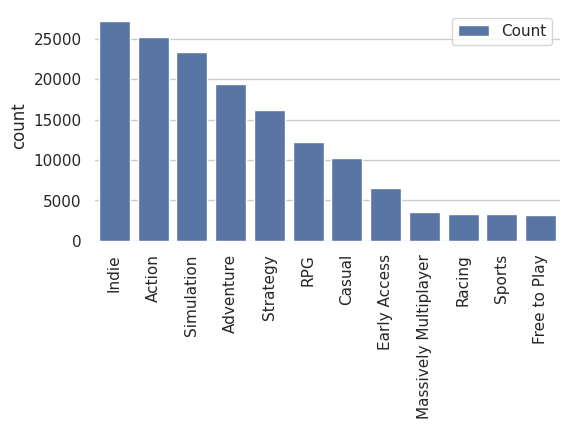

In [6]:
f, ax = plt.subplots(figsize=(6, 3))

sns.barplot(y="count", x="genres", data=metadata.genre_counts, label="Count")
sns.despine(left=True, bottom=True)
ax.set(xlabel="")
ax.tick_params(axis="x", rotation=90)

In [8]:
import typing
from transformers import ConvNextImageProcessor
from steam.models import ConvNextV2ForImbalancedImageClassification

# model_id = "microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft"
model_id = "facebook/convnextv2-huge-22k-512"

image_processor = typing.cast(ConvNextImageProcessor, ConvNextImageProcessor.from_pretrained(model_id))
model = typing.cast(ConvNextV2ForImbalancedImageClassification, ConvNextV2ForImbalancedImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(metadata.id2label),
    id2label=metadata.id2label,
    label2id=metadata.label2id,
    label_weights=metadata.label_weights,
    ignore_mismatched_sizes=True,
))

model.to(device)


ConvNextV2ForImbalancedImageClassification(
  (convnextv2): ConvNextV2Model(
    (embeddings): ConvNextV2Embeddings(
      (patch_embeddings): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextV2LayerNorm()
    )
    (encoder): ConvNextV2Encoder(
      (stages): ModuleList(
        (0): ConvNextV2Stage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextV2Layer(
              (dwconv): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
              (layernorm): ConvNextV2LayerNorm()
              (pwconv1): Linear(in_features=192, out_features=768, bias=True)
              (act): GELUActivation()
              (grn): ConvNextV2GRN()
              (pwconv2): Linear(in_features=768, out_features=192, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextV2Layer(
              (dwconv): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3

torch.Size([3, 384, 384]) ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Indie', 'Massively Multiplayer', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']


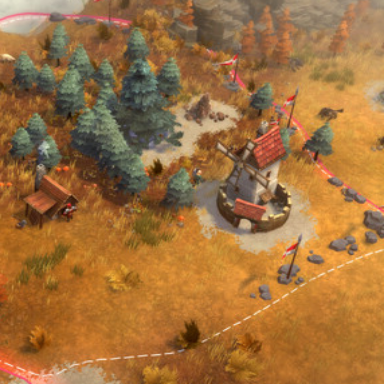

In [10]:
import numpy as np
import PIL.Image

from torchvision.transforms import v2

size = image_processor.size["shortest_edge"]
mean = typing.cast(list[float], image_processor.image_mean)
std = typing.cast(list[float], image_processor.image_std)

transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(size,size), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(p=0.1),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

# Denormalize the pixel values to see that the image is also correctly loaded
def inverse_transform(pixel_values: torch.Tensor) -> PIL.Image.Image:
    unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return PIL.Image.fromarray(unnormalized_image)

inverse_transform(dataset["train"][1]["pixel_values"])

In [11]:
from transformers import TrainingArguments, Trainer, EvalPrediction, IntervalStrategy

from steam.metrics.multi_label import create_multi_label_metrics

metrics = create_multi_label_metrics(positive_label_threshold=metadata.positive_label_threshold)

def data_collator(batch: list[dict[str, torch.Tensor]]):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return { "pixel_values": pixel_values, "labels": labels }

def compute_metrics(p: EvalPrediction):
    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids[0] if isinstance(p.label_ids, tuple) else p.label_ids
    result = metrics(predictions=predictions, labels=labels)
    return result

training_args = TrainingArguments(
    output_dir="./data/steam_genre_classifier",
    remove_unused_columns=False,
    evaluation_strategy=IntervalStrategy.STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_total_limit=10,
    eval_steps=250,
    save_steps=250,
    learning_rate=5e-5,
    weight_decay=0.01,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    label_names=["labels"],
    tf32=True,
    bf16=True,
    optim="adamw_bnb_8bit",
    # Comment these out when testing new models to check for CUDA OOM errors quicker, but for debugging, it just makes things more difficult
    # torch_compile=True,
    # torch_compile_backend="inductor",
    # torch_compile_mode="reduce-overhead"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()